<a href="https://colab.research.google.com/github/kilianBertholon/Apprentissage-profond/blob/main/Fichier_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Rendu Projet Apprentissage Profond </center>

In [1]:
!git clone https://github.com/kilianBertholon/Apprentissage-profond.git

fatal: destination path 'Apprentissage-profond' already exists and is not an empty directory.


Kilian Bertholon  
Guillaume Cobat  
Placé Anthony

# Pré-traitement des données

In [2]:
import csv
import os
import json
import numpy as np

def load_data(nom_dossier="."):
    """
    Fonction de chargement des données
    Attention : Utilise les librairies csv et json. S'assurer que le répertoire de travail est celui où se trouve
    la fonction data_loading.py (sans déplacer les différents fichiers)
    """

    info_obs = {}
    users = []

    print("-- chargement des fichiers csv (observations + labels) --")
    dataset = []
    user_ids = []
    labels = []
    for dir_files in os.listdir(nom_dossier):
        if os.path.isfile(nom_dossier + "/" + dir_files) and dir_files[-3:]=='csv':
            user_id = dir_files.split('_')[0]
            print("Data ", user_id)
            users.append(user_id)
            cur_series = []
            cur_labels = []
            with open(nom_dossier + "/" + dir_files, newline='') as csvfile:
                spamreader = csv.reader(csvfile, delimiter=',', quotechar='\'')
                for i,row in enumerate(spamreader):
                    if i==0:
                        info_obs['observations'] = row[2:5]
                        info_obs['labels'] = row[7]
                    else:
                        cur_series.append([float(v) for v in row[2:5]])
                        cur_labels.append(row[7])
            segmented_series = []
            segmented_labels = []
            cur_lab = "not_labeled"
            cur_ser = []
            for i, (v, l) in enumerate(zip(cur_series, cur_labels)):
                if l != cur_lab:
                    if cur_lab != "not_labeled":
                        segmented_series.append(np.array(cur_ser))
                        segmented_labels.append(cur_lab)
                    cur_ser = []
                    cur_lab = l
                if l != "not_labeled":
                    cur_ser.append(v)
        dataset.extend(segmented_series)
        labels.extend(segmented_labels)
        user_ids.extend([user_id] * len(segmented_series))


    print("-- chargement du fichier json (meta données) --")
    # Opening JSON file
    f = open(os.path.join(nom_dossier, 'meta.json'))
    # returns JSON object as a dictionary
    tmp_meta_data = json.load(f)
    meta_data = {}
    for origin in tmp_meta_data:
        for user_id, user_info in tmp_meta_data[origin].items():
            meta_data[user_id] = user_info
            meta_data[user_id]['origin'] = origin
    # Closing file
    f.close()

    return dataset, labels, user_ids  # info_obs, meta_data

print("Lecture des données")
data_obs, data_labels, user_ids = load_data("Apprentissage-profond/hangtime_har/")
print("Données chargées")

print(data_obs[:5])
print(data_labels[:5])
print(user_ids[:5])

Lecture des données
-- chargement des fichiers csv (observations + labels) --
Data  f2ad
Data  0846
Data  a0da
Data  ce9d
Data  c6f3
Data  2dd9
Data  9bd4
Data  ac59
Data  b512
Data  2dd9
Data  e90f
Data  f2ad
Data  10f0
Data  4991
Data  10f0
Data  0846
Data  ac59
Data  b512
Data  ce9d
Data  4d70
Data  a0da
Data  9bd4
Data  4d70
Data  05d8
-- chargement du fichier json (meta données) --
Données chargées
[array([[-8.696300e-01,  4.062500e-01, -7.570000e-03],
       [-8.453350e-01,  3.846450e-01, -7.690000e-03],
       [-8.210400e-01,  3.630400e-01, -7.810000e-03],
       [-8.430200e-01,  3.161600e-01, -1.880000e-02],
       [-8.664600e-01,  2.849100e-01, -3.320000e-02],
       [-9.113800e-01,  2.890600e-01, -4.565000e-02],
       [-9.899900e-01,  3.278800e-01, -7.886000e-02],
       [-1.053470e+00,  3.767100e-01, -7.349000e-02],
       [-1.183590e+00,  4.177200e-01, -4.688000e-02],
       [-1.285890e+00,  3.295900e-01, -1.562000e-02],
       [-1.391600e+00, -5.727500e-01,  3.166500e-01]

## Création d'un jeu de données de test et d'un jeu d'entrainement

Dans un premier temps, on va se charger de séparer nos données en un jeu d'entrainement et un jeu de test. Pour ce faire, on va séparer chacun des tests de chacun des individus en gardant 90 % des tests de chacun des individus comme des données d'entrainements et 10 % restants comme des données de test. On s'est permis cette transformations car nous possédons beaucoup de données (12000 séries temporelles).

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

unique_users = list(set(user_ids))

data_obs_train = []
data_obs_test = []
data_labels_train = []
data_labels_test = []
user_ids_train = []
user_ids_test = []

#Pour chaque utilisateur, on sépare les données en train et test
for user in unique_users:
    #Extraire les indices correspondant à l'utilisateur
    indices_user = [i for i, u_id in enumerate(user_ids) if u_id == user]

    #Diviser les indices en train et test
    indices_train, indices_test = train_test_split(indices_user, test_size=0.1, random_state=42)

    #Ajouter les données d'entrainements
    data_obs_train.extend([data_obs[i] for i in indices_train])
    data_labels_train.extend([data_labels[i] for i in indices_train])
    user_ids_train.extend([user_ids[i] for i in indices_train])

    #Ajouter les données de test
    data_obs_test.extend([data_obs[i] for i in indices_test])
    data_labels_test.extend([data_labels[i] for i in indices_test])
    user_ids_test.extend([user_ids[i] for i in indices_test])






## Data Augmentation (méthode 1 d'ajustement du nombre de données)

In [5]:
data_obs_augment_train = data_obs_train.copy()
data_labels_augment_train = data_labels_train.copy()


# Fonction pour ajouter du jitter à chaque valeur d'accélération
def add_jitter_to_data(data, factor=0.05):
    jitter = factor * np.random.normal(size=data.shape)
    return data + jitter


#-----------------------------SITTING--------------------------------------------------------------

# Utiliser une liste en compréhension pour obtenir les indices avec le label "sitting"
indices_sitting = [i for i, label in enumerate(data_labels_augment_train) if label == "sitting"]

# Extraire les lignes associées au label "sitting" dans data_obs_train
data_obs_train_sitting = [data_obs_augment_train[i] for i in indices_sitting]
data_labels_train_sitting = [data_labels_augment_train[i] for i in indices_sitting]

# Créer un tableau pour stocker les données augmentées
augmented_data_sitting = []


# Appliquer la data augmentation jitter
for j in range(50): #Fais 10 fois un tour de boucle pour rajouter du random sur les 42 valeurs
  for i in range(len(data_obs_train_sitting)):
      augmented_data_sitting.append(add_jitter_to_data(data_obs_train_sitting[i]))

data_obs_augment_train.extend(augmented_data_sitting)
#print(augmented_data_sitting)

label_a_ajouter = "sitting"

# Ajouter 420 occurrences du label "sitting" à la fin de la liste
data_labels_augment_train.extend([label_a_ajouter] * len(augmented_data_sitting))


#----------------------------STANDING--------------------------------------------------------------

# Utiliser une liste en compréhension pour obtenir les indices avec le label "standing"
indices_standing = [i for i, label in enumerate(data_obs_augment_train) if label == "standing"]

# Extraire les lignes associées au label "sitting" dans data_obs_train
data_obs_train_standing = [data_obs_augment_train[i] for i in indices_standing]
data_labels_train_standing = [data_labels_augment_train[i] for i in indices_standing]

# Créer un tableau pour stocker les données augmentées
augmented_data_standing = []


# Appliquer la data augmentation jitter
for j in range(2): #Fais 10 fois un tour de boucle pour rajouter du random sur les 42 valeurs
  for i in range(len(data_obs_train_standing)):
      augmented_data_standing.append(add_jitter_to_data(data_obs_train_standing[i]))

data_obs_augment_train.extend(augmented_data_standing)
#print(augmented_data_sitting)

label_a_ajouter_2 = "standing"

# Ajouter 420 occurrences du label "sitting" à la fin de la liste
data_labels_augment_train.extend([label_a_ajouter_2] * len(augmented_data_standing))

#--------------------------------------------------------------------------------------------


# Utiliser un dictionnaire pour stocker le nombre d'occurrences de chaque label
occurrences = {}

# Compter le nombre d'occurrences pour chaque label
for label in data_labels_train:
    occurrences[label] = occurrences.get(label, 0) + 1

# Afficher le nombre d'occurrences pour chaque label
for label, count in occurrences.items():
    print(f"Label '{label}': {count} occurrence(s)")

Label 'jumping': 2199 occurrence(s)
Label 'walking': 3654 occurrence(s)
Label 'running': 3546 occurrence(s)
Label 'standing': 947 occurrence(s)
Label 'sitting': 52 occurrence(s)


<ipython-input-5-3c295f287cad>:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  indices_standing = [i for i, label in enumerate(data_obs_augment_train) if label == "standing"]


## Normalisation des données

In [6]:
#Normalisation des données classiques
from sklearn.preprocessing import StandardScaler

data_obs_train_concatenated = np.concatenate(data_obs_train)
data_obs_test_concatenated = np.concatenate(data_obs_test)

# Initialiser le scaler
scaler = StandardScaler()

# Adapter le scaler sur l'ensemble du jeu de données (entraînement + test)
scaler.fit(np.concatenate([data_obs_train_concatenated, data_obs_test_concatenated]))

# Appliquer la transformation sur toutes les séquences d'entraînement et de test
data_obs_train_Norm = [scaler.transform(obs) for obs in data_obs_train]
data_obs_test_Norm = [scaler.transform(obs) for obs in data_obs_test]




# Normalisation des DATA AUGMENTE


data_obs_augment_train_concatenated = np.concatenate(data_obs_augment_train)

# Initialiser le scaler
scaler = StandardScaler()

# Adapter le scaler sur l'ensemble du jeu de données (entraînement + test)
scaler.fit(np.concatenate([data_obs_augment_train_concatenated, data_obs_test_concatenated]))

# Appliquer la transformation sur toutes les séquences d'entraînement et de test
data_obs_augment_train_Norm = [scaler.transform(obs) for obs in data_obs_augment_train]
data_obs_augment_test_Norm = [scaler.transform(obs) for obs in data_obs_test]

## Longueur de chaque série temporelle

Analyse du nombre de classes de y dans le jeu de test et dans le jeu d'apprentissage :

In [7]:
print('Il y a ', len(np.unique(data_labels_train)), ' classes dans les données d\'entraînement')
print('Il y a ', len(np.unique(data_labels_test)), ' classes dans les données de test')
print('Il y a ', len(np.unique(data_labels)), ' classes dans les données totales')


print('dif label en entrainement : ', np.unique(data_labels_train))
print('dif label en test : ',np.unique(data_labels_test))
print('dif label au total : ',np.unique(data_labels))

Il y a  5  classes dans les données d'entraînement
Il y a  5  classes dans les données de test
Il y a  5  classes dans les données totales
dif label en entrainement :  ['jumping' 'running' 'sitting' 'standing' 'walking']
dif label en test :  ['jumping' 'running' 'sitting' 'standing' 'walking']
dif label au total :  ['jumping' 'running' 'sitting' 'standing' 'walking']


*Les labels sont bien les mêmes dans les jeux d'entrainements et de tests et correspondent bien à ceux du jeu de base*
  
    
Dans notre cas, il serait préférables d'avoir des séquences de tailles identiques ( plus simple pour la convergence des informations)  
On va donc chercher à rajouter du padding (séries de 0 pour complémenter le manque d elongueur sur certaines séquences) ou a réaliser du troncage (garder uniquement la partie la plus importante de chaque série pour obtenir des informations de même taille)

In [8]:
num_sequences = len(data_obs_train_Norm)

# Afficher la longueur de chaque séquence
for i in range(min(5,num_sequences)):
    print(f"Longueur de la séquence {i + 1}: {len(data_obs_train[i])}")

Longueur de la séquence 1: 43
Longueur de la séquence 2: 225
Longueur de la séquence 3: 760
Longueur de la séquence 4: 28
Longueur de la séquence 5: 201


On voit ici que les séquences sont très variables. On va donc analyser la densité de chaque longueur de séquences afin d'obtenir des informations sur les données que l'on possède. Par la suite nous réaliserons le padding ou le troncage pour obtenir des longueurs de séries temporelles identiques.

#### Jeu de données d'entrainement

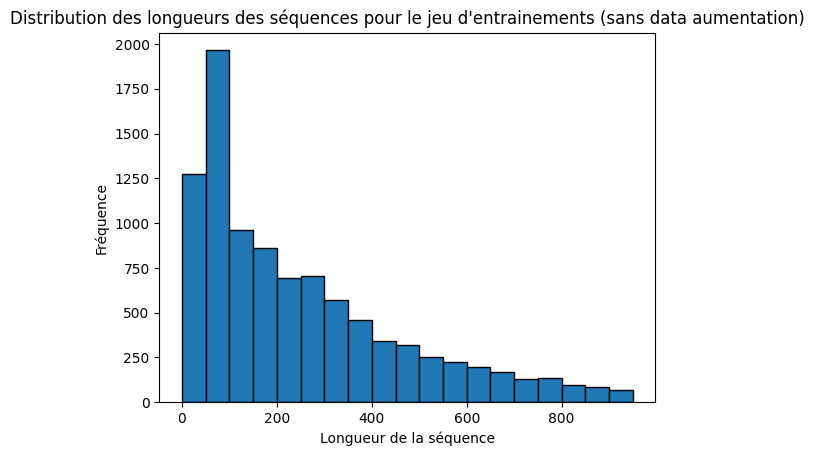

Longueur minimale : 1
Longueur maximale : 46004
Longueur moyenne : 478.30159646085787


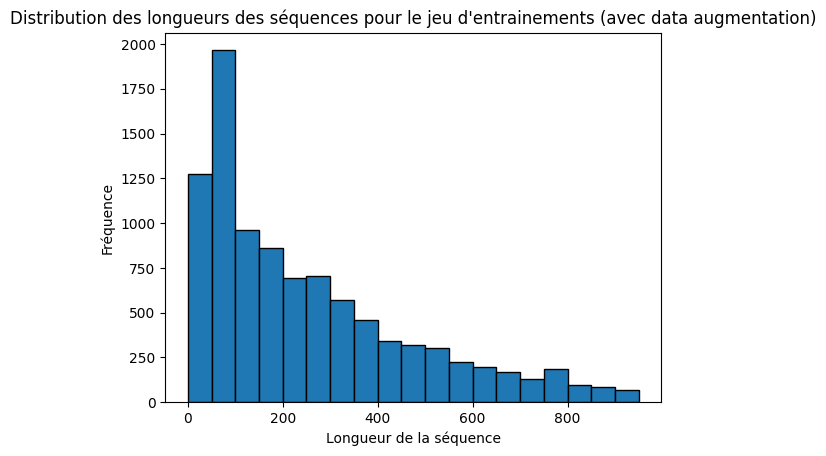

Longueur minimale : 1
Longueur maximale : 46004
Longueur moyenne : 2091.704877673488


In [12]:
import matplotlib.pyplot as plt

# Calculer la longueur de chaque séquence
sequence_lengths = [len(seq) for seq in data_obs_train_Norm]

bins = np.arange(0, 1000, 50)
# Afficher un histogramme
plt.hist(sequence_lengths, bins=bins, edgecolor='black')
plt.title('Distribution des longueurs des séquences pour le jeu d\'entrainements (sans data aumentation)')
plt.xlabel('Longueur de la séquence')
plt.ylabel('Fréquence')
plt.show()

min_length = min(sequence_lengths)
max_length = max(sequence_lengths)
mean_length = np.mean(sequence_lengths)

print(f"Longueur minimale : {min_length}")
print(f"Longueur maximale : {max_length}")
print(f"Longueur moyenne : {mean_length}")


# Calculer la longueur de chaque séquence
sequence_lengths_2 = [len(seq) for seq in data_obs_augment_train]

bins = np.arange(0, 1000, 50)
# Afficher un histogramme
plt.hist(sequence_lengths_2, bins=bins, edgecolor='black')
plt.title('Distribution des longueurs des séquences pour le jeu d\'entrainements (avec data augmentation)')
plt.xlabel('Longueur de la séquence')
plt.ylabel('Fréquence')
plt.show()

min_length_2 = min(sequence_lengths_2)
max_length_2 = max(sequence_lengths_2)
mean_length_2 = np.mean(sequence_lengths_2)

print(f"Longueur minimale : {min_length_2}")
print(f"Longueur maximale : {max_length_2}")
print(f"Longueur moyenne : {mean_length_2}")

#### Jeu de données de test

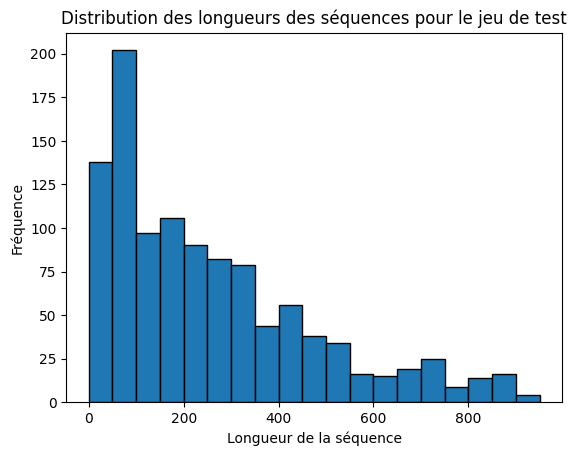

Longueur minimale : 9
Longueur maximale : 11785
Longueur moyenne : 431.65606190885643


In [13]:
import matplotlib.pyplot as plt

# Calculer la longueur de chaque séquence
sequence_lengths = [len(seq) for seq in data_obs_test]

bins = np.arange(0, 1000, 50)
# Afficher un histogramme
plt.hist(sequence_lengths, bins=bins, edgecolor='black')
plt.title('Distribution des longueurs des séquences pour le jeu de test')
plt.xlabel('Longueur de la séquence')
plt.ylabel('Fréquence')
plt.show()

min_length = min(sequence_lengths)
max_length = max(sequence_lengths)
mean_length = np.mean(sequence_lengths)

print(f"Longueur minimale : {min_length}")
print(f"Longueur maximale : {max_length}")
print(f"Longueur moyenne : {mean_length}")

## Padding

Test avec padding = 2000 car moyenne du jeu de données d'entrainements

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

data_obs_train_Norm_pad = []
data_obs_train_Norm_pad = pad_sequences(data_obs_train_Norm, maxlen=600, padding='post', dtype='float32')

data_obs_test_Norm_pad = []
data_obs_test_Norm_pad = pad_sequences(data_obs_test_Norm, maxlen=600, padding='post', dtype='float32')

#Padding DATA AUGMENTE

data_obs_augment_train_Norm_pad = []
data_obs_augment_train_Norm_pad = pad_sequences(data_obs_augment_train_Norm, maxlen=600, padding='post', dtype='float32')

data_obs_augment_test_Norm_pad = []
data_obs_augment_test_Norm_pad = pad_sequences(data_obs_augment_test_Norm, maxlen=600, padding='post', dtype='float32')


## Encodage des labels

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Encoder les labels en entiers
labels_encoder = LabelEncoder()
labels_train_int = labels_encoder.fit_transform(data_labels_train)
labels_test_int = labels_encoder.fit_transform(data_labels_test)

#Encoder les labels en one-hot
labels_onehot = OneHotEncoder(sparse=False, categories='auto')
labels_train_onehot = labels_onehot.fit_transform(labels_train_int.reshape(-1, 1))
labels_test_onehot = labels_onehot.fit_transform(labels_test_int.reshape(-1, 1))


# ENCODAGE DES LABELS DATA AUGMENTE

labels_augment_train_int = labels_encoder.fit_transform(data_labels_augment_train)

labels_augment_train_onehot = labels_onehot.fit_transform(labels_augment_train_int.reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Attribution de poids aux variables (méthode 2 d'ajustement du nombre de données)

Configurer l'attribution de poids pour la comparaison entre ajout de poids ou data augmentation


In [16]:
def get_custom_sample_weight(y):
    """Return custom sample weights."""
    y = np.asarray(y)

    # Définir les poids personnalisés pour chaque classe
    class_weights = {0: 1.0, 1: 1.0, 2: 10.0, 3: 10.0, 4: 1.0}  # Modifiez selon vos besoins

    sample_weight = []

    for label in y:
        idx, *__ = np.where(label == 1)
        sample_weight += [max([class_weights[i] for i in idx])]

    return np.array(sample_weight)

# Utilisation de la fonction pour obtenir les poids personnalisés
custom_sample_weights = get_custom_sample_weight(labels_train_onehot)

# Convertir les étiquettes one-hot en noms d'étiquettes
class_labels = ['jumping', 'running', 'sitting', 'standing', 'walking']
predicted_labels = [class_labels[np.argmax(label)] for label in labels_train_onehot]

# Convertir les étiquettes one-hot en indices de classe
class_indices = np.argmax(labels_train_onehot, axis=1)

# Initialiser un dictionnaire pour stocker un exemple pour chaque classe
examples_by_class = {class_label: None for class_label in set(class_indices)}

# Parcourir les exemples et remplir le dictionnaire
for i, class_index in enumerate(class_indices):
    if examples_by_class[class_index] is None:
        examples_by_class[class_index] = i

# Afficher un exemple pour chaque classe
for class_label, example_index in examples_by_class.items():
    print(f"Classe {class_label}: Poids = {custom_sample_weights[example_index]}")
    print(f"   Exemple {example_index + 1} : {labels_train_onehot[example_index]}")
    print(f"   Label: {predicted_labels[example_index]}")

Classe 0: Poids = 1.0
   Exemple 1 : [1. 0. 0. 0. 0.]
   Label: jumping
Classe 1: Poids = 1.0
   Exemple 7 : [0. 1. 0. 0. 0.]
   Label: running
Classe 2: Poids = 10.0
   Exemple 345 : [0. 0. 1. 0. 0.]
   Label: sitting
Classe 3: Poids = 10.0
   Exemple 17 : [0. 0. 0. 1. 0.]
   Label: standing
Classe 4: Poids = 1.0
   Exemple 2 : [0. 0. 0. 0. 1.]
   Label: walking


Pour être sur de ne pas se tromper on va créer les deux manières et on comparera pour chacun des test les deux manières de faire

## Comparaison des modèles

### Réseau RNN 1 couche

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, Input
from keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor='val_loss',patience=3, min_delta=0.01, restore_best_weights=True, verbose=2)


def model_rnn_basique(T, D, nb_classes):
  input = Input(shape = (T, D))
  Couche_rec = SimpleRNN(64)(input)
  dense1 = Dense(nb_classes, activation = "sigmoid")(Couche_rec)
  model = Model(inputs=input, outputs=dense1)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=["accuracy"])
  model.summary()
  return model


In [18]:
model_rnn = model_rnn_basique(600, 3, 5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 3)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                4352      
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 4677 (18.27 KB)
Trainable params: 4677 (18.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Test data classique (utilisation sans la data augmentée mais padding en utilisant un peu plus que la moyenne des observations sans data augmentation)



In [19]:
history_rnn_simple = model_rnn.fit(data_obs_train_Norm_pad, labels_train_onehot, epochs=10, batch_size=256, validation_data=(data_obs_test_Norm_pad, labels_test_onehot),  callbacks=[cb])

Epoch 1/10
41/41 [==============================] - 22s 494ms/step - loss: 1.3987 - accuracy: 0.3149 - val_loss: 1.3079 - val_accuracy: 0.2984
Epoch 2/10
41/41 [==============================] - 16s 398ms/step - loss: 1.3199 - accuracy: 0.3548 - val_loss: 1.2909 - val_accuracy: 0.4101
Epoch 3/10
41/41 [==============================] - 17s 426ms/step - loss: 1.2975 - accuracy: 0.3758 - val_loss: 1.2775 - val_accuracy: 0.3431
Epoch 4/10
41/41 [==============================] - 14s 351ms/step - loss: 1.3518 - accuracy: 0.3868 - val_loss: 1.3194 - val_accuracy: 0.3998
Epoch 5/10
41/41 [==============================] - 14s 350ms/step - loss: 1.4653 - accuracy: 0.3327 - val_loss: 1.2997 - val_accuracy: 0.3414
Epoch 6/10
41/41 [==============================] - 15s 358ms/step - loss: 1.3097 - accuracy: 0.3660 - val_loss: 1.2859 - val_accuracy: 0.3964
Epoch 6: early stopping


Avec data augmentée

In [24]:
model_rnn_data_augmentee = model_rnn_basique(600, 3, 5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600, 3)]          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                4352      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4677 (18.27 KB)
Trainable params: 4677 (18.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history_rnn_data_augment = model_rnn_data_augmentee.fit(data_obs_augment_train_Norm_pad, labels_augment_train_onehot, epochs=10, batch_size=256, validation_data=(data_obs_test_Norm_pad, labels_test_onehot),  callbacks=[cb])

Epoch 1/10
51/51 [==============================] - 17s 335ms/step - loss: 1.2148 - accuracy: 0.4738 - val_loss: 1.3505 - val_accuracy: 0.3611
Epoch 2/10
51/51 [==============================] - 19s 364ms/step - loss: 1.1880 - accuracy: 0.4665 - val_loss: 1.3565 - val_accuracy: 0.3637
Epoch 3/10
51/51 [==============================] - 19s 362ms/step - loss: 1.1694 - accuracy: 0.4719 - val_loss: 1.3430 - val_accuracy: 0.3766
Epoch 4/10
51/51 [==============================] - 17s 336ms/step - loss: 1.1557 - accuracy: 0.4850 - val_loss: 1.3340 - val_accuracy: 0.3801
Epoch 5/10
51/51 [==============================] - 17s 335ms/step - loss: 1.1564 - accuracy: 0.4755 - val_loss: 1.3195 - val_accuracy: 0.3955
Epoch 6/10
51/51 [==============================] - 18s 354ms/step - loss: 1.1938 - accuracy: 0.4656 - val_loss: 1.3639 - val_accuracy: 0.3766
Epoch 7/10
51/51 [==============================] - 18s 349ms/step - loss: 1.1415 - accuracy: 0.4877 - val_loss: 1.3291 - val_accuracy: 0.3835

Avec poids et sans data augmentation

In [27]:
history_rnn_poids = model_rnn.fit(data_obs_train_Norm_pad, labels_train_onehot, epochs=10, batch_size=256, validation_data=(data_obs_test_Norm_pad, labels_test_onehot),sample_weight=custom_sample_weights,  callbacks=[cb])

Epoch 1/10
41/41 [==============================] - 15s 367ms/step - loss: 2.6248 - accuracy: 0.1611 - val_loss: 1.6567 - val_accuracy: 0.1015
Epoch 2/10
41/41 [==============================] - 18s 446ms/step - loss: 2.4417 - accuracy: 0.1135 - val_loss: 1.7045 - val_accuracy: 0.1006
Epoch 3/10
41/41 [==============================] - 14s 342ms/step - loss: 2.4181 - accuracy: 0.1154 - val_loss: 1.6861 - val_accuracy: 0.1023
Epoch 4/10
41/41 [==============================] - 14s 344ms/step - loss: 2.4204 - accuracy: 0.1181 - val_loss: 1.6811 - val_accuracy: 0.1066
Epoch 4: early stopping


Comparaison des 3 modalités

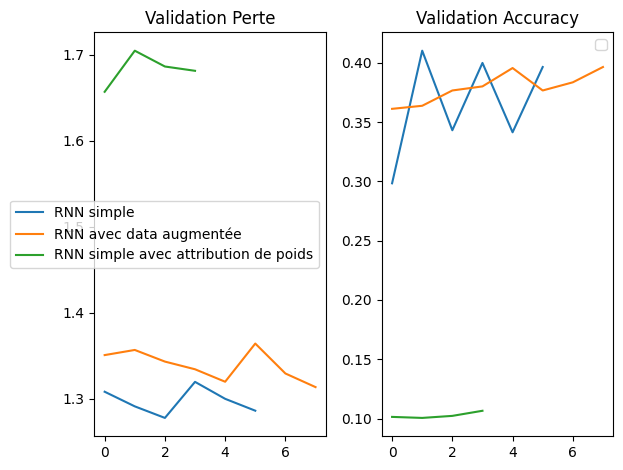

In [28]:
# Visualiser l'évolution de la perte et de la précision au fil des épochs
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(history_rnn_simple.history['val_loss'], label='RNN simple')
plt.plot(history_rnn_data_augment.history['val_loss'], label='RNN avec data augmentée')
plt.plot(history_rnn_poids.history['val_loss'], label='RNN simple avec attribution de poids')
plt.title('Validation Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn_simple.history['val_accuracy'])
plt.plot(history_rnn_data_augment.history['val_accuracy'])
plt.plot(history_rnn_poids.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

**Ici on voit donc bien que les meilleures résultats sont ceux qui utilisent les données de data augmentées tout en conservant les valeurs de padding à 600**

### Réseau RNN 2 couche

In [29]:
def model_rnn_avance(T, D, nb_classes):
  input = Input(shape = (T, D))
  Couche_rec = SimpleRNN(64, return_sequences=True)(input)
  Couche_rec2 = SimpleRNN(32)(Couche_rec)
  dense1 = Dense(nb_classes, activation = "sigmoid")(Couche_rec2)
  model = Model(inputs=input, outputs=dense1)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=["accuracy"])
  model.summary()
  return model



In [30]:
model_rnn_avance = model_rnn_avance(600, 3, 5)
history_rnn_avance = model_rnn_avance.fit(data_obs_augment_train_Norm_pad, labels_augment_train_onehot, epochs=10, batch_size=500, validation_data=(data_obs_test_Norm_pad, labels_test_onehot),  callbacks=[cb])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 600, 3)]          0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 600, 64)           4352      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 7621 (29.77 KB)
Trainable params: 7621 (29.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 28s 979ms/step - loss: 1.4478 - accuracy: 0.3730 - val_loss: 1.3857 - val_accuracy: 0.3620
Epoch 2/10
26/

### Modèle LSTM

In [40]:
# Definition du modèle
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Flatten
def model_lstm(T, D, nb_classes):
  input = Input(shape = (T, D))
  Couche_rec = LSTM(64, return_sequences=True)(input)
  Couche_rec2 = LSTM(32)(Couche_rec)
  dense1 = Dense(nb_classes, activation = "sigmoid")(Couche_rec2)
  model = Model(inputs=input, outputs=dense1)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=["accuracy"])
  model.summary()
  return model

In [41]:
model_lstm = model_lstm(600, 3, 5)
history_lstm = model_lstm.fit(data_obs_train_Norm_pad, labels_train_onehot, epochs=10, batch_size=500, validation_data=(data_obs_test_Norm_pad, labels_test_onehot),  callbacks=[cb])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 600, 3)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 600, 64)           17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
Total params: 29989 (117.14 KB)
Trainable params: 29989 (117.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 7s 113ms/step - loss: 1.5128 - accuracy: 0.3192 - val_loss: 1.3405 - val_accuracy: 0.3431
Epoch 2/10


### LSTM Bidirectionnal


In [37]:
# Definition du modèle
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Flatten, Bidirectional
def model_lstm_bidi(T, D, nb_classes):
  input = Input(shape = (T, D))
  Couche_rec = Bidirectional(LSTM(128, return_sequences=True))(input)
  Couche_rec2 = Bidirectional(LSTM(128, return_sequences = True))(Couche_rec)
  Couche_rec3 = Bidirectional(LSTM(64, return_sequences = True))(Couche_rec2)
  Couche_rec4 = Bidirectional(LSTM(64, return_sequences = True))(Couche_rec3)
  Flatten1 = Flatten()(Couche_rec4)
  dense1 = Dense(32, activation = "relu")(Flatten1)
  dense2 = Dense(nb_classes, activation = "softmax")(dense1)
  model = Model(inputs=input, outputs=dense2)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=["accuracy"])
  model.summary()
  return model

In [38]:
model_lstm_bidi = model_lstm_bidi(600, 3, 5)
history_lstm_bidi = model_lstm_bidi.fit(data_obs_train_Norm_pad, labels_train_onehot, epochs=20, batch_size=256, validation_data=(data_obs_test_Norm_pad, labels_test_onehot))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 600, 3)]          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 600, 256)          135168    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 600, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 600, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 600, 128)          98816     
 onal)                                                     

37/37 [==============================] - 5s 72ms/step


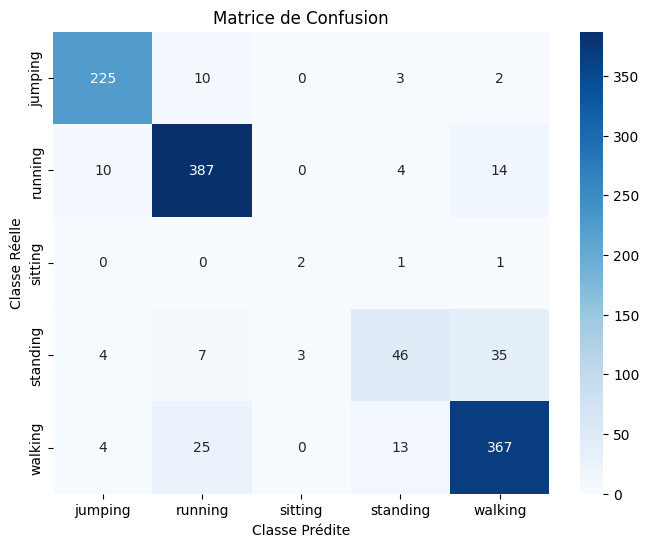

Précision globale : 88.31%


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# Après l'entraînement du modèle
y_pred = model_lstm_bidi.predict(data_obs_test_Norm_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test_onehot, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = np.unique(data_labels)


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()

# Calcul et affichage de la précision globale
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Précision globale : {accuracy * 100:.2f}%")

Les résultats commencent à devebir intéressant avec ce modèle

### LSTM avancée

In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

def lstm_avance(T, D, nb_classes):
  model = Sequential()
  model.add(LSTM(units = 128, input_shape = (T, D)))
      # Dropout layer
  model.add(Dropout(0.5))
# Dense layer with ReLu
  model.add(Dense(units = 64, activation='relu'))
# Softmax layer
  model.add(Dense(nb_classes, activation = 'softmax'))
# Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [43]:
lstm_avance = lstm_avance(600, 3, 5)
history_lstm_avancee = lstm_avance.fit(data_obs_train_Norm_pad, labels_train_onehot, epochs=10, batch_size=500, validation_data=(data_obs_test_Norm_pad, labels_test_onehot),  callbacks=[cb])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                                                 
Total params: 76165 (297.52 KB)
Trainable params: 76165 (297.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 6s 114ms/step - loss: 1.4734 - accuracy: 0.3597 - val_loss: 1.2891 - val_accuracy: 0.4351
Epoch 2/

### CNN


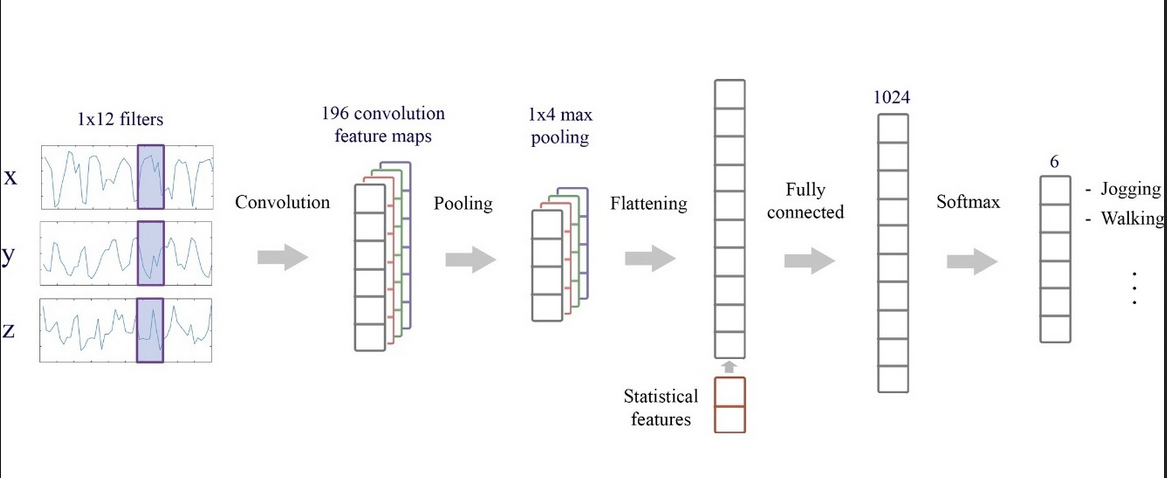

In [44]:
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Flatten, Bidirectional, InputLayer, Conv2D, MaxPool2D, Masking
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import EarlyStopping


cb = EarlyStopping(monitor='val_accuracy',patience=5, min_delta=0.2, restore_best_weights=True, verbose=2)

def cnn_model(T, D, nb_classes):
  model = Sequential([
      InputLayer(input_shape = (T, D, 1)),
      Conv2D(filters=196, kernel_size= (12, 1), strides=1, padding='same', activation='relu'),
      MaxPool2D(pool_size=(1, 4), strides=1, padding='same'),
      Flatten(),
      Dense(units=nb_classes, activation='softmax')
  ])
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=["accuracy"])
  model.summary()
  return model

Execution sans poids


In [45]:
model_cnn = cnn_model(600, 3, 5)
history_cnn = model_cnn.fit(data_obs_train_Norm_pad, labels_train_onehot, epochs=20, batch_size=256, validation_data=(data_obs_test_Norm_pad, labels_test_onehot))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 3, 196)       2548      
                                                                 
 max_pooling2d (MaxPooling2  (None, 600, 3, 196)       0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 352800)            0         
                                                                 
 dense_11 (Dense)            (None, 5)                 1764005   
                                                                 
Total params: 1766553 (6.74 MB)
Trainable params: 1766553 (6.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
41/41 [==============================] - 8s 63ms/step - loss: 0.9541 - 

Execution avec poids et sans data augmentation


In [46]:
model_cnn_poids = cnn_model(600, 3, 5)
history_cnn_poids = model_cnn_poids.fit(data_obs_train_Norm_pad, labels_train_onehot,
                             epochs=20, batch_size=256,
                             validation_data=(data_obs_test_Norm_pad, labels_test_onehot),
                             sample_weight=custom_sample_weights)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 600, 3, 196)       2548      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 600, 3, 196)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 352800)            0         
                                                                 
 dense_12 (Dense)            (None, 5)                 1764005   
                                                                 
Total params: 1766553 (6.74 MB)
Trainable params: 1766553 (6.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
41/41 [==============================] - 5s 57ms/step - loss: 2.7731 - 

Matrice de confusion sans data augmentation

37/37 [==============================] - 0s 5ms/step


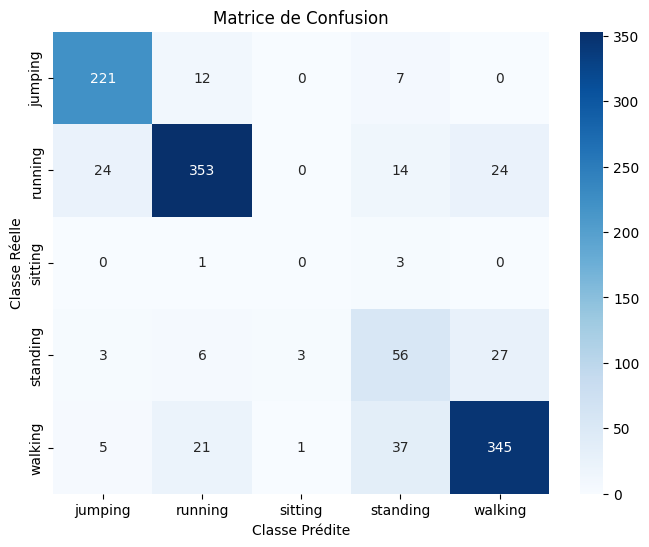

Précision globale : 83.83%


In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# Après l'entraînement du modèle
y_pred = model_cnn.predict(data_obs_test_Norm_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test_onehot, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = np.unique(data_labels)


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()

# Calcul et affichage de la précision globale
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Précision globale : {accuracy * 100:.2f}%")

Matrice de confusion avec poids attribué aux variables

37/37 [==============================] - 0s 5ms/step


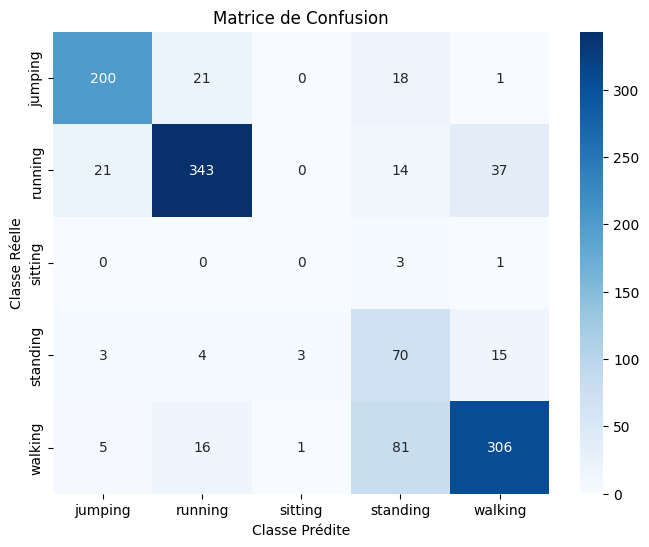

Précision globale : 79.02%


In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# Après l'entraînement du modèle
y_pred = model_cnn_poids.predict(data_obs_test_Norm_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test_onehot, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = np.unique(data_labels)


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()

# Calcul et affichage de la précision globale
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Précision globale : {accuracy * 100:.2f}%")

## Graphique de comparaison

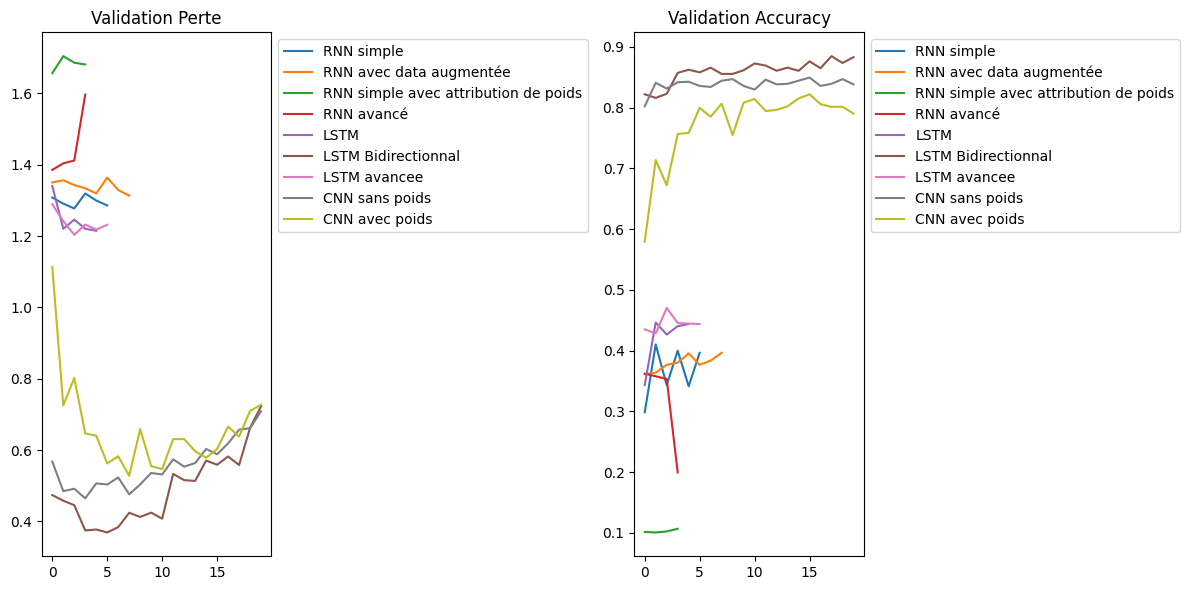

In [50]:
import matplotlib.pyplot as plt

# Ajuster la taille du graphique
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_rnn_simple.history['val_loss'], label='RNN simple')
plt.plot(history_rnn_data_augment.history['val_loss'], label='RNN avec data augmentée')
plt.plot(history_rnn_poids.history['val_loss'], label='RNN simple avec attribution de poids')
plt.plot(history_rnn_avance.history['val_loss'], label='RNN avancé')
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_lstm_bidi.history['val_loss'], label='LSTM Bidirectionnal')
plt.plot(history_lstm_avancee.history['val_loss'], label='LSTM avancee')
plt.plot(history_cnn.history['val_loss'], label='CNN sans poids')
plt.plot(history_cnn_poids.history['val_loss'], label='CNN avec poids')

plt.title('Validation Perte')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(1, 2, 2)
plt.plot(history_rnn_simple.history['val_accuracy'], label='RNN simple')
plt.plot(history_rnn_data_augment.history['val_accuracy'], label='RNN avec data augmentée')
plt.plot(history_rnn_poids.history['val_accuracy'], label='RNN simple avec attribution de poids')
plt.plot(history_rnn_avance.history['val_accuracy'], label='RNN avancé')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.plot(history_lstm_bidi.history['val_accuracy'], label='LSTM Bidirectionnal')
plt.plot(history_lstm_avancee.history['val_accuracy'], label='LSTM avancee')
plt.plot(history_cnn.history['val_accuracy'], label='CNN sans poids')
plt.plot(history_cnn_poids.history['val_accuracy'], label='CNN avec poids')

plt.title('Validation Accuracy')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

## Conclusion

Pour conclure après avoir essayé différentes transformations de données, les modèles qui semblent les plus précis pour identifier nos données sont :
*   Le LTSM Bidirectionnal
*   CNN classique  

Nous avons également essayer différentes transformations pour aboutir à de meilleures détections. Dans un premier temps nous avons essayé de travailler sur le processus de **normalisation des données** (Standardisation vs normalisation vs standardisation percentile (différentes valeurs) vs standardisation Z-score. Nous avons donc après test en validation croisée défini de partit sur un standardisation classique à partir du packages sklearn.  

Par la suite nous avons essayé de transformées nos données pour obtenir plus d'informations à partir de cela, nous nous sommes intéressés à la vitesse (obtenus à partir de la dérivée de l'accélérations (la problèmatique de la période d'échantillonage c'est posé).  

Nous avons également investigué sur l'utilisation de la variation de position (dérivée secondes de l'accélérations) mais encore la même problématique qui s'est posé.  
Des méthodes de filtrage ont également été testées sans réussite (filtre passe-haut, passe-bas et butterworth). Les résultats n'étaient pas meilleurs.  

Enfin nous avons essayé de travaillé sur le domaine fréquentiel en passant par l'utilisation de la transformée de Fourrier (sans pour autant plus de résultat).

Pour finir nous avons essayé d'augmenter la dimensionnalité de nos données car toutes n'étions pas présentes de la même manière (les données de sitting et de standing étaient beaucoup moins présentes que les restes (40 x moins de sitting que de jumping ou de running)). Cependant, nos résultats après transformations (via la méthode de jitting) étaient globalement plus lents (car plus de données à traiter en entrainement) et/ou pas plus performants (au mieux performance identique et sinon moins performants). Sur le même principe, nous avons également essayé d'attribuer du poids aux variables mais sans résultat également.